In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [5]:
# Load pre-processed data
Poore_BRCA = pd.read_csv("Poore_BRCA", index_col=0)
Poore_BRCA

,f__Halomonadaceae; g__Cobetia,f__Thermoanaerobacteraceae; g__Ammonifex,f__Cryomorphaceae; g__Owenweeksia,f__Haloplasmataceae; g__Haloplasma,f__Desulfobacteraceae; g__Desulfosarcina,f__Enterobacteriaceae; g__Siccibacter,f__Acetobacteraceae; g__Asaia,f__Rhodobiaceae; g__Parvibaculum,g__Neosynechococcus,f__Sphingomonadaceae; g__Zymomonas,...,portion_weight,aliquot_concentration,analyte_A260A280Ratio,analyte_amount,analyte_type_label,radiation_therapy_code_label,radiation_therapy_site_label,radiation_therapy_type_label,year_of_diagnosis,vital_status_label
sample_id1,,,,,,,,,,,,,,,,,,,,,
s6501,1.103111,2.393026,1.924050,0.679874,2.855614,1.895898,1.458905,3.822917,1.950597,-0.154784,...,130.0,0.17,1.83,40.77,RNA,22C40DCA-0F16-42B4-A28F-29FEAC78B565,Primary Tumor Field,External,2006.0,Alive
s6522,1.479929,2.791636,3.893348,1.100076,1.041926,2.250654,1.840587,1.874406,2.362581,0.172999,...,30.0,0.13,1.78,11.94,RNA,NaN,NaN,NaN,2006.0,Alive
s6459,1.829156,1.794873,1.326145,-1.380102,1.031621,3.272754,1.028514,0.890885,2.840755,1.436739,...,30.0,0.08,2.03,77.70,DNA,NaN,NaN,NaN,2008.0,Alive
s6574,1.925188,2.057109,1.619184,1.862043,1.877224,1.131113,0.605902,1.251608,1.261155,-0.685010,...,30.0,0.16,1.82,5.14,RNA,4B8B651E-F54C-4EB0-AC3F-BFEFB8E3BF05,Regional site,External,2001.0,Alive
s6538,4.256201,2.029458,1.700561,0.391692,1.804504,3.399491,3.777331,5.799079,1.599825,-0.371001,...,40.0,0.17,1.84,22.61,RNA,CF613056-FC7D-4604-89E3-ABBBC28E70AD,Primary Tumor Field,External,2008.0,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s6812,0.347136,2.064020,1.626095,0.283991,1.703563,1.138024,2.197776,1.258519,1.268067,-0.678099,...,30.0,0.15,1.84,48.65,RNA,B0A03CE9-A77F-43D8-8C34-8F37099E4531,Primary Tumor Field,EXTERNAL BEAM,2010.0,Alive
s6761,-0.265530,2.306996,1.883595,2.950444,1.731282,1.077936,1.040480,1.514738,1.401018,1.890969,...,30.0,0.09,1.83,75.68,DNA,45D50414-CE7E-456B-BB0F-D49E70BB491D,Not available,Not available,2010.0,Alive
s6831,3.630990,2.289707,1.624344,0.509342,0.820343,3.046717,3.608684,1.215478,4.027831,1.147350,...,30.0,0.16,1.76,28.56,RNA,NaN,NaN,NaN,1994.0,Dead


In [6]:
class_counts = Poore_BRCA['sample_type'].value_counts()
print(class_counts)

sample_type
Primary Tumor           1238
Solid Tissue Normal      129
Blood Derived Normal     107
Metastatic                 9
Name: count, dtype: int64


In [7]:
# Prepare features and target variable
X = Poore_BRCA.drop(['gdc_file_uuid', 'filename', 'age_at_diagnosis', 'aliquot_uuid',
       'case_uuid', 'days_to_death', 'disease_type', 'ethnicity',
       'experimental_strategy', 'gender', 'investigation', 'platform',
       'primary_site', 'race', 'reference_genome', 'sample_type',
       'sample_uuid', 'vital_status', 'tissue_source_site_label',
       'data_submitting_center_label', 'country_of_sample_procurement',
       'histological_diagnosis_label', 'pathologic_t_label',
       'pathologic_n_label', 'pathologic_stage_label', 'icd03_histology_label',
       'icd03_histology_site', 'icd10', 'portion_is_ffpe',
       'new_tumor_event_after_initial_trtmt',
       'primary_therapy_outcome_success_label', 'portion_weight',
       'aliquot_concentration', 'analyte_A260A280Ratio', 'analyte_amount',
       'analyte_type_label', 'radiation_therapy_code_label',
       'radiation_therapy_site_label', 'radiation_therapy_type_label',
       'year_of_diagnosis', 'vital_status_label'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled
y = Poore_BRCA['sample_type']
print("Unique values of y:", np.unique(y))
le = LabelEncoder()
y = le.fit_transform(y)
y
print("Unique values of y:", np.unique(y))

Unique values of y: ['Blood Derived Normal' 'Metastatic' 'Primary Tumor' 'Solid Tissue Normal']
Unique values of y: [0 1 2 3]


In [8]:
# Oversampling to ensure class balance
oversampler = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_scaled, y = oversampler.fit_resample(X_scaled,y)
print(X_scaled.shape)
print(y.shape)

(4952, 1273)
(4952,)


In [9]:
# Feature selection
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

random_seed = 42
lsvc = LinearSVC(C = 0.01, penalty="l1", dual=False).fit(X_scaled, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_scaled)

X_new.shape

(4952, 502)

Best Parameters: {'alpha': 0.1, 'eta': 0.01, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 100}
Best Score: 0.9884580677087881
Test Set Accuracy: 0.9784656796769852


<Figure size 800x600 with 0 Axes>

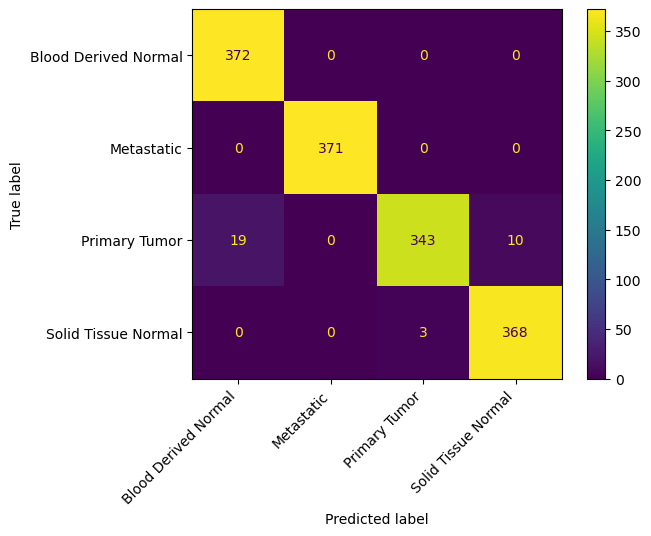

In [12]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

# Define parameters for XGBoost model
params = {
    'learning_rate':[0.01, 0.1],
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1],
    #'lambda': [0.1, 1]
    'alpha': [0.01, 0.1], # Include L1 regularization
    'n_estimators': [50, 100]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', seed=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the model on the test set
test_score = grid_search.best_estimator_.score(X_test, y_test)
print("Test Set Accuracy:", test_score)

y_pred = grid_search.best_estimator_.predict(X_test)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Blood Derived Normal', 'Metastatic', 'Primary Tumor', 'Solid Tissue Normal'])
plt.figure(figsize=(8, 6))
cm_display.plot()
plt.xticks(rotation=45, ha='right')
plt.show()

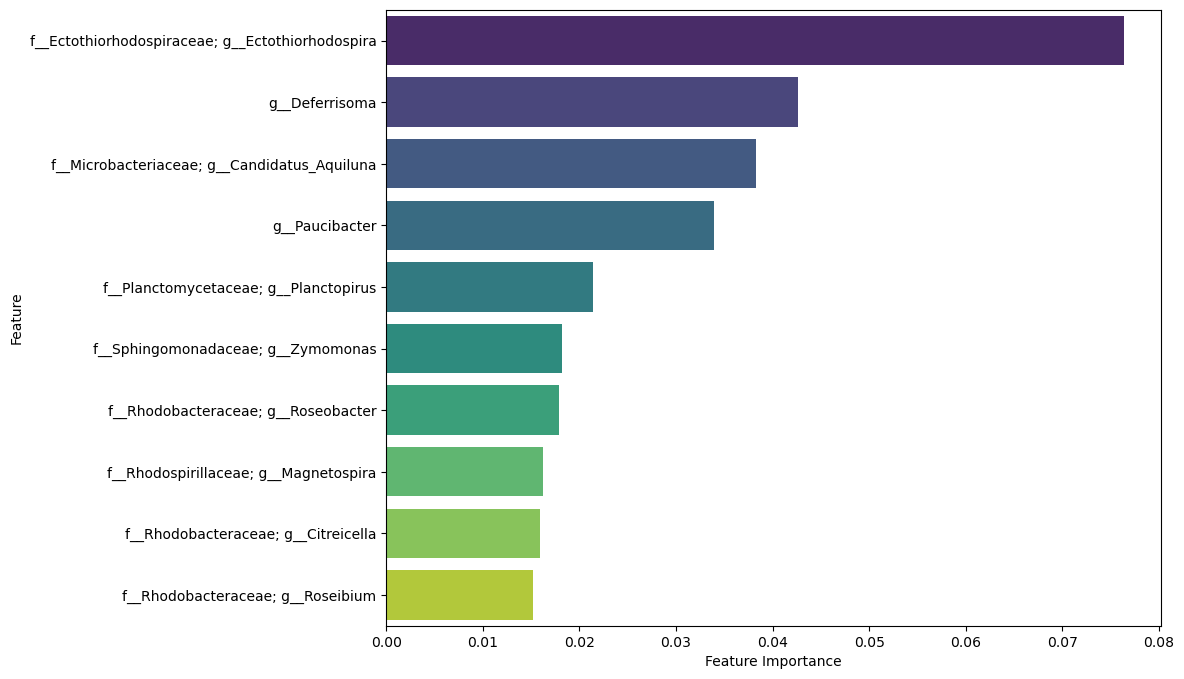

In [13]:
# Train XGBoost model with best parameters for calculating feature importances
best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss', **best_params)
best_xgb_model.fit(X_train, y_train)

feature_importances = best_xgb_model.feature_importances_
top_10_indices = feature_importances.argsort()[::-1][:10]
feature_names = X.columns

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[top_10_indices], y=feature_names[top_10_indices], palette="viridis")
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

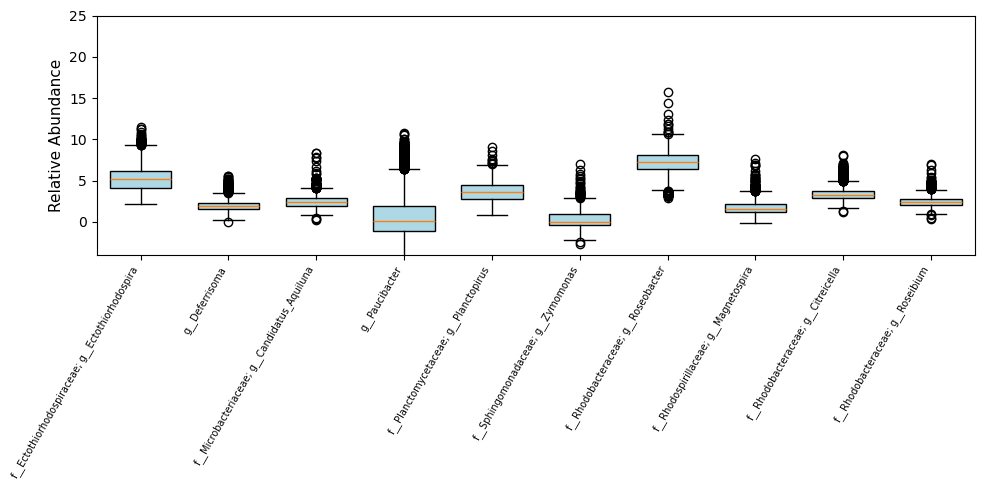

In [15]:
# Box plot for visualizing bacterial relative abundance of 10 most important bacteria

data = {}
top_20_feature_names = feature_names[top_10_indices]
#abundance_scaled = np.log2(X)

for column_name in top_20_feature_names:
    data[column_name] = X[column_name]

plt.figure(figsize=(10, 5))
plt.boxplot(data.values(), widths=0.7, patch_artist=True, 
            boxprops=dict(facecolor='lightblue'), whiskerprops=dict(color='black'))

plt.ylim(-4, 25)
plt.ylabel('Relative Abundance', fontsize=11)
plt.xticks(range(1, len(data) + 1), data.keys(), rotation=60, ha='right', fontsize=7)
plt.tight_layout()
plt.show()